# Graph Convolution Networks in XENONnT
#### Alex Oranday
Within this notebook, I'll be taking a rough look at how a Graph Convolution Networks (GCN) could be applied to the hit pattern data coming in from XENONnT. The deep learning will be accomplished using PyTorch and PyTorch Geometric.

In [1]:
import torch
from tqdm import tqdm
import numpy as np
import pickle as pk
import os.path as osp
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Sequential, ReLU, Dropout
from lrcurve import PlotLearningCurve

## **Setting up a Dataset**
First, we'd need to set up a Dataset through PyTorch Geometric. To keep within their language, a Data object could be a singular graph. In our case, this Data object is a graph where each node is a light sensor in XENONnT and holds the attributes of the x and y positions of that sensor and the area of the waveform that sensor saw.
These Data objects can also hold the targets to train against, which would be the true event position for us. The connection of these nodes can be specified by a COO format or be taken in from a few other package formats, such as from **networkx** as is used here. The connection used here was made by Delaunay triangulation from scipy and was chosen for being well connected without being definitely overconnected.

![title](./delaunay_imgs/pmt_graph_delaunay_1T.png)

![title](./delaunay_imgs/pmt_adj_delaunay_1T.png)
![title](./delaunay_imgs/pmt_degree_delaunay_1T.png)
![title](./delaunay_imgs/pmt_laplacian_delaunay_1T.png)

The data source that is being used here is available in fried rice at `/data/wfsim/WFsim_training_patterns/disk_const_PE/A_const_1000__Z_const_-1/WFsim_A_const_1000__Z_const_-1_N10000_000000.hdf5` . This data source contains 10,000 events that were uniformly distributed for x and y positions, but with a constant z position of -1 cm. Each event simulated for 1,000 electrons.

To match some of the data I was using previously, I processed this into a pickle that contains only the area per channel for an event and the true position for that event.

In [2]:
import os

class CustomDataset(Dataset):
    def __init__(self, root, raw_name, graph_name, proc_name=None, train=False, transform=None, pre_transform=None):
        """
        Desired directory structure:
            root
            |---- raw
            |     |---- raw_name
            |     |---- graph_name
            |     |---- other_raw_name
            |     |---- other_graph_name
            |     |---- ...
            |---- processed
            |     |---- proc_name
            |           |---- graph_0.pt
            |           |---- graph_1.pt
            |           |---- ...
            |     |---- other_proc_name
            |           |---- graph_0.pt
            |           |---- graph_1.pt
            |     |---- ...

        Original Torch Inputs:
            root = The path to the root directory (str). raw_name and graph_name should be located
                somewhere within here.
            transform = Function on how to transform the data
            pre_transform = Function on what data would pass through before transform
        Custom Inputs:
            train = Indicate whether to use the training data (true) or the validation data (false)
            raw_name = The raw file name to pull data from (str)
            proc_name = The proccessed directory name to place data into (str)
            graph_name = File name of a pickle that contains networkx graph that describes the
                desired graph to work with.
        """
        self.train = train
        self.raw_name = raw_name
        self.graph_name = graph_name
        if proc_name == None: # Use the raw_name for the subdirectory name
            self.proc_name = raw_name.split('.')[0] # Removing file extensions
        else:
            self.proc_name = proc_name
        self.content_size = 0
        if osp.isdir( osp.join(root, 'processed', self.proc_name, "") ):
            self.content_size = len(os.listdir(osp.join(root, 'processed', self.proc_name, "")))
        super(CustomDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.raw_name

    @property
    def processed_file_names(self):
        return self.proc_name

    def process(self):
        """
        Processes the raw files into the appropriate processed files if they don't already exist.
        """
        # Getting the desired graph structure
        with open( osp.join(self.root, 'raw', self.graph_name), 'rb' ) as fn:
            input_graph = pk.load(fn)
        torch_graph = from_networkx(input_graph)

        # Starting to process the file names in raw_paths which pulls from raw_file_names
        # Directory structure: self.root -> 'raw' -> self.raw_file_names
        # Will only contain one raw_path
        i=0
        for raw_path in self.raw_paths:
            with open(raw_path, 'rb') as fn:
                raw_contents = pk.load(fn)
            self.content_size += len(raw_contents)
            for raw_data in raw_contents:
                # Preparing the graph's node features: hit pattern results and x,y position of
                # sensor
                x = raw_data['area_per_channel'][:127] # Want only the top PMTs
                x = np.reshape( x, (len( x ), 1) )
                x = np.hstack( (x, np.array(torch_graph.pos)) ).astype(np.float32)

                # Target position to train against
                y = np.reshape( raw_data['true_pos'],
                        (1, len(raw_data['true_pos'])) )

                proc_data = Data(x=torch.tensor(x), edge_index=torch_graph.edge_index,
                        y=torch.tensor(y), pos=torch_graph.pos)

                # Want to save contents into a common directory
                if type(self.proc_name) == str:
                    path_to_proc = osp.join(self.processed_dir, self.proc_name)
                else:
                    print("No name to give the processed subdirectory. Using the raw name as",
                            "subdirectory name")
                    path_to_proc = osp.join(self.processed_dir, raw_name)

                # path_to_proc: self.root --> 'processed' --> proc_name or raw_name
                if not osp.isdir(path_to_proc):
                    os.makedirs(path_to_proc)
                torch.save(proc_data, osp.join( path_to_proc, 'graph_{}.pt'.format(i) ))
                i += 1

    def get(self, idx):
        """ Get the graph_{}.pt for idx from the processed_dir. """
        if type(self.proc_name) == str:
            path_to_proc = osp.join(self.processed_dir, self.proc_name)
        else:
            print("No name to give the processed subdirectory. Using the raw name as",
                    "subdirectory name")
            path_to_proc = osp.join(self.processed_dir, self.raw_name)

        # Use the first 80% as training and the last 20% for validation
        if self.train:
            idx_shift = 0
        else:
            idx_shift = int(self.content_size * 0.8)

        proc_graph_path = osp.join(path_to_proc, 'graph_{}.pt'.format(idx+idx_shift))
        return torch.load(proc_graph_path)
    
    def len(self):
        if self.train:
            return int(0.8*self.content_size)
        return int(0.2*self.content_size)

### Single Simulations & Multiple Simulations
The simulations files that I use can be taken as a single dataset or be combined into a larger dataset. For the case of the larger dataset, a list of the file names needs to passed to CustomDataset instead.

In [3]:
sim_list = ['{}-50000_1000_el_z-10_sim.pkl'.format(ID) for ID in range(12,14)]
# sim_list.pop(34)

In [4]:
# Produces 100,000 simulation points
batch_size = 10000
valid_dataset = CustomDataset('/home/aeoranday/learning_data', sim_list, 'nx-graph_delaunay_top_pmt_1T.pkl', proc_name='dead-1T_100000')
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
train_dataset = CustomDataset('/home/aeoranday/learning_data', sim_list, 'nx-graph_delaunay_top_pmt_1T.pkl', proc_name='dead-1T_100000', train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [5]:
# Produces 10,000 simulation points
batch_size = 5
valid_dataset = CustomDataset('/home/aeoranday/learning_data', "andrii_A-1000_Z-1_N-10000.pkl", 'nx-graph_top_pmt.pkl')
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
train_dataset = CustomDataset('/home/aeoranday/learning_data', "andrii_A-1000_Z-1_N-10000.pkl", 'nx-graph_top_pmt.pkl', train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [5]:
print(train_dataset)
print(valid_dataset)

CustomDataset(80000)
CustomDataset(20000)


## **Network Structure**
This is the current network structure. It makes use of multiple layers of graph convolutions and a final fully connected layer to condense back down into an x,y position. With the nodes having 3 features at the start -- area and x,y positions -- we build up from there.

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(28*127, 16),
                              ReLU(),
                              Linear(16, 2))
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 28)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = x.view(batch_size, -1)
        return self.lin(x)

This is to send the network to run under cuda instead of a cpu. If a cpu is desired instead, simply replace "cuda" with "cpu". This is also the step where I choose which optimizer to use: Adam. PyTorch has multiple optimizers available, such as: Adagrad, ASGD, Rprop.

In [7]:
torch.cuda.set_device(1)
device = torch.device("cuda")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

Here I calculate the number of trainable parameters by getting the number of elements in a parameter and keeping those that are going to need gradients to be computed.

In [8]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

57486


In [9]:
len(valid_loader)

2

In [ ]:
# Training and Testing
# torch.cuda.empty_cache()
epoch_lim = 1000
epoch_min = epoch
plot = PlotLearningCurve(
    mappings = {
        'loss': {'line':'train', 'facet':'loss'},
        'val_loss': {'line':'validation', 'facet':'loss'}
    },
    facet_config = {
        'loss': {'name': 'MSE Loss', 'limit':[0,None], 'scale':'linear'}
    },
    xaxis_config = {'name': 'Epoch', 'limit':[epoch_min,epoch_min+epoch_lim]}
)
if epoch_min == 0:
    train_lst = []
    train_L1 = []
    valid_lst = []
    valid_L1 = []
epochs = tqdm(range(epoch_min,epoch_min+epoch_lim), leave=False)
tol = 1e-5
break_count = 0
with plot:
    for epoch in epochs:
        err_train = 0
        L1_err = 0
        err_valid = 0
        cnt_train = 0
        cnt_valid = 0
        model.train()
        batch_num = 0
        for batch in train_loader:
#             print("Which batch?", batch_num)
#             torch.cuda.empty_cache()
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            err = F.mse_loss(out, batch.y)
            L1_err += F.l1_loss(out, batch.y)#.cpu().detach().item()
            err_train += err
            err.backward()
            cnt_train += 1
            optimizer.step()
#             batch_num += 1
#             del batch
#             del out
#             del err
#         print("Pre-append.")
        train_lst.append(err_train.cpu().detach().item() / cnt_train)
        train_L1.append(L1_err.cpu().detach().item() / cnt_train)
        # Cleanup
#         del err_train
#         del L1_err
#         torch.cuda.empty_cache()
        
        L1_err = 0
#         print("Pre-eval.")
        model.eval()
        batch_num = 0
        for batch in valid_loader:
#             print("Which batch?", batch_num)
            batch = batch.to(device)
            pred = model(batch)
            err_valid += F.mse_loss(pred, batch.y)
            L1_err += F.l1_loss(pred, batch.y)
            cnt_valid += 1
#             batch_num += 1
#             del batch
#             del pred
        valid_lst.append(err_valid.cpu().detach().item() / cnt_valid)
        valid_L1.append(L1_err.cpu().detach().item() / cnt_valid)
        epochs.set_description("Training: {}. Valid: {}".format(train_lst[-1], valid_lst[-1]))
        epochs.refresh()
        plot.append(epoch, {
            'loss': train_lst[-1],
            'val_loss': valid_lst[-1]
        })
        plot.draw()
        if epoch > 1000:
            if valid_lst[-1] > valid_lst[-2]:
                if break_count >= 20:
                    print("Stopping early at {}.".format(epoch))
                    break
                else:
                    break_count += 1

<IPython.core.display.Javascript object>

Training: 0.17633673548698425. Valid: 0.17561176419258118:  29%|██▉       | 293/1000 [1:51:52<4:29:47, 22.90s/it]

## **Plotting Results**
Simply plotting MSE error for training and validation over epochs.

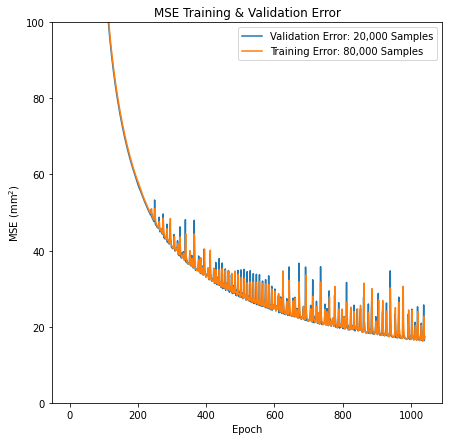

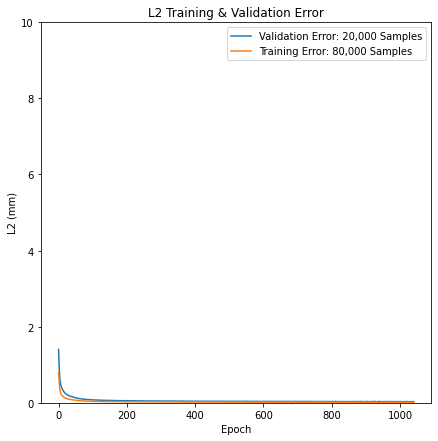

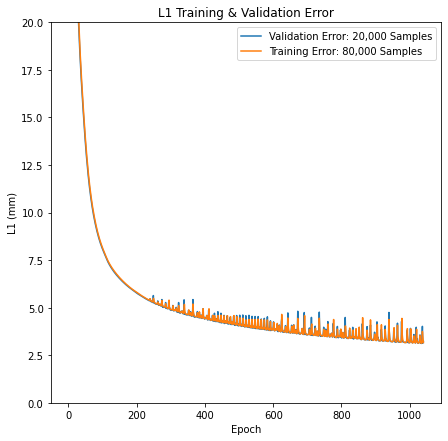

In [21]:
import matplotlib.pyplot as plt
# MSE
plt.figure(figsize=(7,7))
plt.title('MSE Training & Validation Error')
plt.xlabel('Epoch')
plt.ylabel(r'MSE (mm$^2$)')
plt.plot(range(len(valid_lst)), 100*np.array(valid_lst))
plt.plot(range(len(train_lst)), 100*np.array(train_lst))
# plt.yscale('log')
plt.ylim((0,100))
plt.legend(['Validation Error: 20,000 Samples', 'Training Error: 80,000 Samples'])
# L2
plt.figure(figsize=(7,7))
plt.title('L2 Training & Validation Error')
plt.xlabel('Epoch')
plt.ylabel(r'L2 (mm)')
plt.plot(range(len(valid_lst)), 10*np.sqrt(np.array(valid_lst)/20000))
plt.plot(range(len(train_lst)), 10*np.sqrt(np.array(train_lst)/80000))
plt.ylim((0,10))
plt.legend(['Validation Error: 20,000 Samples', 'Training Error: 80,000 Samples'])
# L1
plt.figure(figsize=(7,7))
plt.title('L1 Training & Validation Error')
plt.xlabel('Epoch')
plt.ylabel(r'L1 (mm)')
plt.plot(range(len(valid_L1)), 10*np.array(valid_L1))
plt.plot(range(len(train_L1)), 10*np.array(train_L1))
plt.ylim((0,20))
# Radial histograms
plt.legend(['Validation Error: 20,000 Samples', 'Training Error: 80,000 Samples'])
#plt.yscale('log')
plt.show()

In [22]:
valid_lst[-1]

0.17350786924362183

In [23]:
torch.save(model.state_dict(), '/home/aeoranday/learning_data/models/1T_GCN28_Partial.pth')
# model.load_state_dict(torch.load('/home/aeoranday/learning_data/models/GCN32.pth'))
# model.eval()

In [15]:
true_valid_pos = np.array([['x','y']])
pred_valid_pos = np.array([['x','y']])
for batch in valid_loader:
    true_valid_pos = np.append(true_valid_pos, np.array(batch.y.detach().cpu()), axis=0)
    batch = batch.to(device)
    pred_valid_pos = np.append(pred_valid_pos, np.array(model(batch).detach().cpu()), axis=0)

true_valid_pos = true_valid_pos[1:].astype(float)
pred_valid_pos = pred_valid_pos[1:].astype(float)
print(true_valid_pos.shape)
print(pred_valid_pos.shape)

(20000, 2)
(20000, 2)


In [13]:
import matplotlib.colors as colors

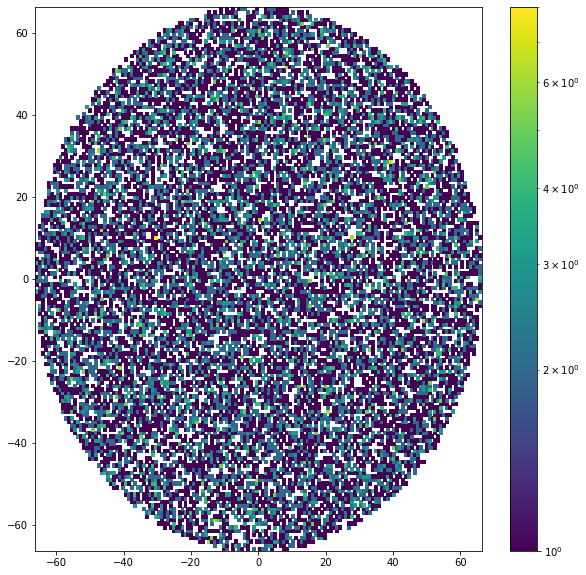

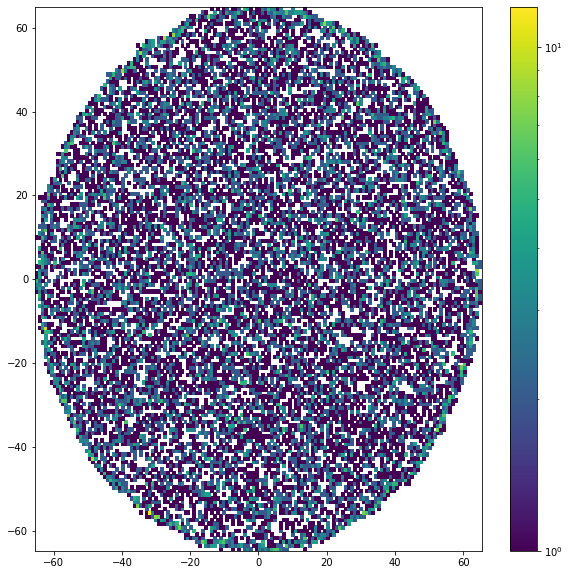

In [23]:
plt.figure(figsize=(10,10))
params = {'image.cmap': 'viridis'}
plt.rcParams.update(params)
plt.hist2d(true_valid_pos[:,0], true_valid_pos[:,1], bins=150, norm=colors.LogNorm())
plt.colorbar()

plt.figure(figsize=(10,10))
plt.rcParams.update(params)
plt.hist2d(pred_valid_pos[:,0], pred_valid_pos[:,1], bins=150, norm=colors.LogNorm())
plt.colorbar()


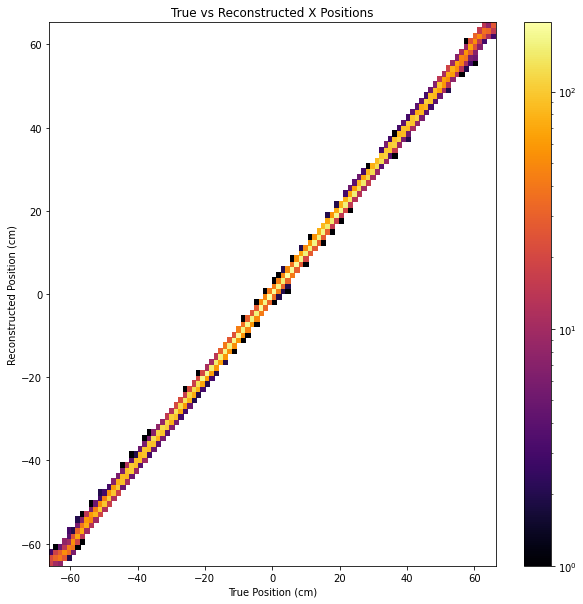

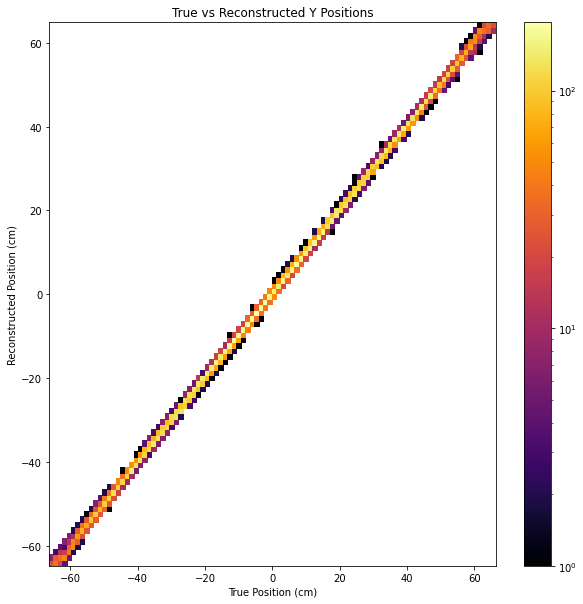

In [18]:
plt.figure(figsize=(10,10))
params = {
    'image.cmap': 'inferno'
}
plt.rcParams.update(params)
plt.hist2d(true_valid_pos[:,0], pred_valid_pos[:,0], bins=100, norm=colors.LogNorm())
plt.colorbar()
plt.title('True vs Reconstructed X Positions')
plt.xlabel('True Position (cm)')
plt.ylabel('Reconstructed Position (cm)')

plt.figure(figsize=(10,10))
plt.hist2d(true_valid_pos[:,1], pred_valid_pos[:,1], bins=100, norm=colors.LogNorm())
plt.colorbar()
plt.title('True vs Reconstructed Y Positions')
plt.xlabel('True Position (cm)')
plt.ylabel('Reconstructed Position (cm)')
plt.show()

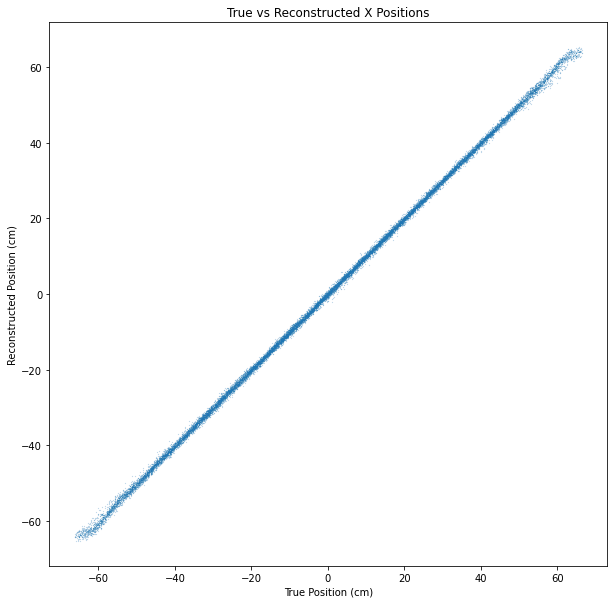

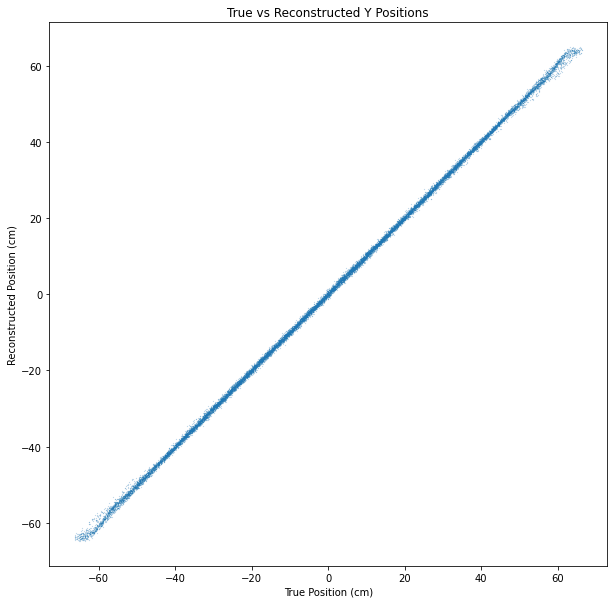

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(true_valid_pos[:,0], pred_valid_pos[:,0], s=0.01)
plt.title('True vs Reconstructed X Positions')
plt.xlabel('True Position (cm)')
plt.ylabel('Reconstructed Position (cm)')

plt.figure(figsize=(10,10))
plt.scatter(true_valid_pos[:,1], pred_valid_pos[:,1], s=0.01)
plt.title('True vs Reconstructed Y Positions')
plt.xlabel('True Position (cm)')
plt.ylabel('Reconstructed Position (cm)')

plt.show()

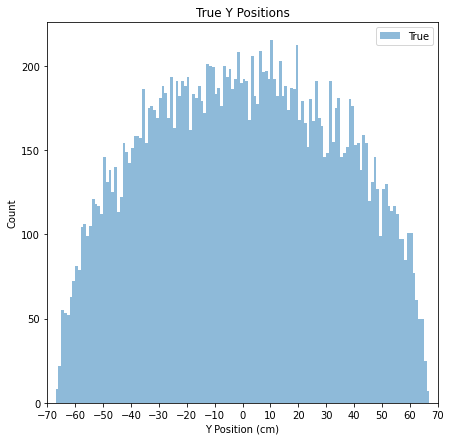

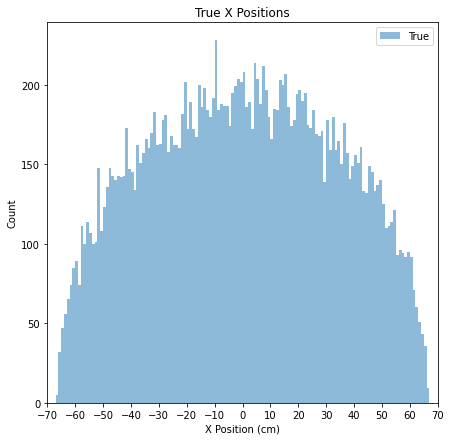

In [47]:
plt.figure(figsize=(7,7))
plt.hist(true_valid_pos[:,1], bins=np.arange(-70,71,1), align='mid', range=[-70,70], alpha=0.5, label='True')
# plt.hist(pred_valid_pos[:,1], bins=np.arange(-70,71,10), align='mid', range=[-70,70], alpha=0.5, label='Predicted')
plt.xlim(-70, 70)
plt.xticks(np.arange(-70,71,10))
plt.legend()
plt.title('True Y Positions')
plt.xlabel('Y Position (cm)')
plt.ylabel('Count')

plt.figure(figsize=(7,7))
plt.hist(true_valid_pos[:,0], bins=np.arange(-70,71,1), align='mid', range=[-70,70], alpha=0.5, label='True')
# plt.hist(pred_valid_pos[:,0], bins=np.arange(-70,71,10), align='mid', range=[-70,70], alpha=0.5, label='Predicted')
plt.xlim(-70, 70)
plt.xticks(np.arange(-70,71,10))
plt.legend()
plt.title('True X Positions')
plt.xlabel('X Position (cm)')
plt.ylabel('Count')

plt.show()

In [14]:
min(valid_lst)

0.3669848144054413

Minimum values in _valid_list_:

Learning Rate = 1e-4

0.518 cm^2 on GCN (3,9,27)

0.433 cm^2 on GCN (3,16,64), 16 Linears, 10,000 points, 75 epochs

0.275 cm^2 on GCN (3,16,64), 16 Linears, 100,000 points, 150 epochs

0.236 cm^2 on GCN (3,32,64), 16 Linears, 100,000 points

0.234 cm^2 on GCN (3,16,32), 16 Linears, 100,000 points, 240 epochs

0.378 cm^2 on GCN (3,12,64), 16 Linears, 100,000 points, 89 epochs

0.227 cm^2 on GCN (3,24,64), 16 Linears, 100,000 points, 156 epochs

0.506 cm^2 on GCN (3,16,72), 16 Linears, 100,000 points, 101 epochs

0.307 cm^2 on GCN (3,16,60), 16 Linears, 100,000 points, 171 epochs
Interesting cycling that occurred near the end of learning

0.212 cm^2 on GCN (3,16,28), 16 Linears, 100,000 points, 387 epochs. **Stopped early at 387. Not multiple runs.**

0.305 cm^2 on GCN (3,16,28), 16 Linears, 500,000 points, >>> epochs.

Learning Rate = 1e-5

0.447 cm^2 on GCN (3,16,64), 16 Linears, 100,000 points, 260 epochs. Continuing this run for more.

Saving some previous performance values to continue a bit more on some runs.

In [ ]:
prev_ending = epoch
prev_valid_mse=(valid_lst)
prev_train_mse=(train_lst)
prev_valid_L1=(valid_L1)
prev_train_L1=(train_L1)

In [ ]:
prev_ending